#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite difference/collocation methods

Consider the boundary value problem

$$ \begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b . \end{gather} $$

$f(x)$ is the "forcing" term and we have a Dirichlet boundary condition at the left end of the domain and a Neumann condition on the right end.  We need to choose
* how to represent $u(x)$, including evaluating it on the boundary,
* how to compute derivatives of $u$,
* in what sense to ask for the differential equation to be satisfied,
* where to evaluate $f(x)$ or integrals thereof,
* how to enforce boundary conditions.

## The framework

* Finite difference (FD) methods choose to represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_0 < x_1 < \dotsb < x_n = 1 . $$
The FD framework does not uniquely specify the solution values at points outside this discrete set.
* FD computes derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).  This will be our main focus.
* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* FD methods evaluate the forcing term $f$ pointwise at $x_i$.
* FD methods approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

## Differencing formulas

How can we compute $\frac{du}{dx}(x_i)$ using $u_i$ and $u_{i+1}$?  How accurate is this approximation?

### Taylor series

Without loss of generality, we may assume $x_i = 0$ by shifting our function.  For notational convenience, we will also define $h = x_{i+1} - x_i$.
To determine the order of accuracy, we represent the function $u(x)$ by its Taylor series
$$ u(x) = u(0) + u'(0)x + u''(0)x^2/2! + O(x^3)$$
and substitute into the differencing formula
$$ \begin{split} u'(0) \approx \frac{u(h) - u(0)}{h} = h^{-1} \Big( u(0) + u'(0) h + u''(0)h^2/2 + O(h^3) - u(0) \Big) \\
= u'(0) + u''(0)h/2 + O(h^2) . \end{split}$$
Evidently the error in this approximation is $u''(0)h/2 + O(h^2)$. We say this method is *first order accurate*.

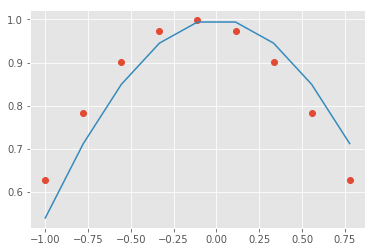

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

n = 10
h = 2/(n-1)
x = numpy.linspace(-1,1,n)
u = numpy.sin(x)
pyplot.plot(x[:-1], (u[1:] - u[:-1]) / h, 'o')
pyplot.plot(x[:-1], numpy.cos(x[:-1]));

This "has the right shape", but the numerical approximation is "shifted" to the left of the analytic derivative. If we differenced to the left, it would be shifted the other way.

####  Is the centered difference formula better?

Here we try

$$ \begin{split} u'(0) \approx \frac{u(h) - u(-h)}{2h} \\
= (2h)^{-1} \Big( \big[ u(0) + u'(0)h + u''(0)h^2/2 + u'''(0)h^3/6 + O(h^4) \Big] - \big[ u(0) - u'(0)h + u''(0)h^2/2 - u'''(0)h^3/6 + O(h^4) \big] \Big) \\
= u'(0) + u'''(0)h^2/6 + O(h^3) \end{split} $$

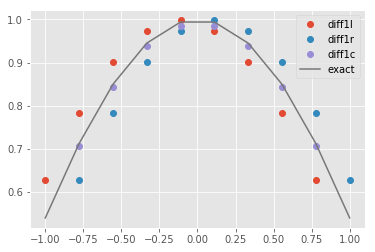

In [2]:
def diff1l(x, u):
    return x[:-1], (u[1:] - u[:-1]) / (x[1:] - x[:-1])

def diff1r(x, u):
    return x[1:],  (u[1:] - u[:-1]) / (x[1:] - x[:-1])

def diff1c(x, u):
    return x[1:-1], (u[2:] - u[:-2]) / (x[2:] - x[:-2])

for diff in (diff1l, diff1r, diff1c):
    xx, yy = diff(x, u)
    pyplot.plot(xx, yy, 'o', label=diff.__name__)
pyplot.plot(x, numpy.cos(x), label='exact')
pyplot.legend(loc='upper right');

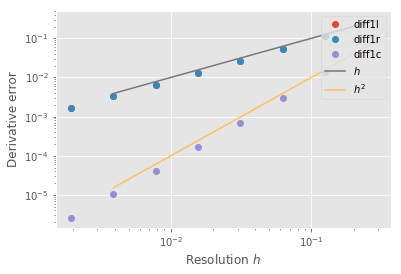

In [3]:
grids = 2**numpy.arange(3,10)
def grid_refinement_error(f, fp, diff):
    error = []
    for n in grids:
        x = numpy.linspace(-1, 1, n)
        xx, yy = diff(x, f(x))
        error.append(numpy.linalg.norm(yy - fp(xx), numpy.inf))
    return grids, error

for diff in (diff1l, diff1r, diff1c):
    ns, error = grid_refinement_error(numpy.sin, numpy.cos, diff)
    pyplot.loglog(1/ns, error, 'o', label=diff.__name__)
hs = 2 / (grids - 1)
pyplot.loglog(hs, hs, label='$h$')
pyplot.loglog(hs, hs**2, label='$h^2$')
pyplot.xlabel('Resolution $h$')
pyplot.ylabel('Derivative error')
pyplot.legend(loc='upper right');

#### Stability

Are there "rough" functions for which these differencing formulas estimate $u'(x_i) = 0$?

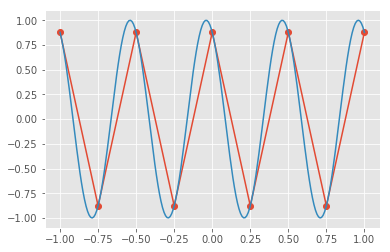

In [4]:
x = numpy.linspace(-1, 1, 9)
xfine = numpy.linspace(-1, 1, 200)
def f_rough(x):
    return numpy.cos(.5+4*numpy.pi*x)
def fp_rough(x):
    return -4*numpy.pi * numpy.sin(.5+4*numpy.pi*x)

pyplot.plot(x, f_rough(x), 'o-')
pyplot.plot(xfine, f_rough(xfine), '-');

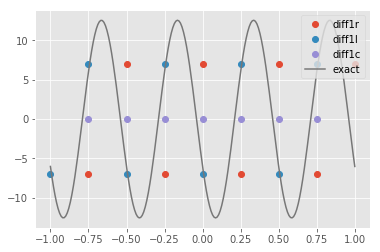

In [5]:
for diff in (diff1r, diff1l, diff1c):
    xx, yy = diff(x, f_rough(x))
    pyplot.plot(xx, yy, 'o', label=diff.__name__)
pyplot.plot(xfine, fp_rough(xfine), label='exact')
pyplot.legend(loc='upper right');

We have this function $f_{\text{rough}}(x)$ that is rough at the grid scale and has derivative identically zero according to the centered difference formula.  Except perhaps for boundary conditions (which we'll consider later), given any solution $u(x)$ to a differential equation discretized using the centered difference approximation, $$\tilde u(x) = u(x) + f_{\text{rough}}(x)$$ would also be a solution.  This non-uniqueness is a disaster for numerical algorithms and in most cases, the centered difference formula is not used directly to compute first derivatives.

When assessing a discretization we require **both accuracy and stability**.

### Second derivatives

We will need at least three grid points to compute a second derivative.
* Why?

Again, there is more than one possible approach.
* One method is to use a first derivative formula to compute $u'(x_{i+1})$ and $u'(x_{i-1})$, then apply the centered first derivative again.
* Another is to define some "staggered" points $x_{i+1/2}$ and $x_{i-1/2}$.

Why should we choose one over the other? Can we understand this in terms of accuracy and stability?

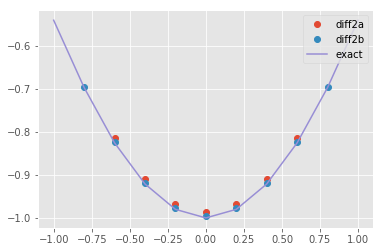

In [6]:
def diff2a(x, u):
    xx, yy = diff1c(x, u)
    return diff1c(xx, yy)

def diff2b(x, u):
    xx, yy = diff1l(x, u)
    return diff1r(xx, yy)

x = numpy.linspace(-1, 1, 11)
u = numpy.cos(x)
for diff2 in (diff2a, diff2b):
    xx, yy = diff2(x, u)
    pyplot.plot(xx, yy, 'o', label=diff2.__name__)
pyplot.plot(x, -numpy.cos(x), label='exact')
pyplot.legend(loc='upper right');

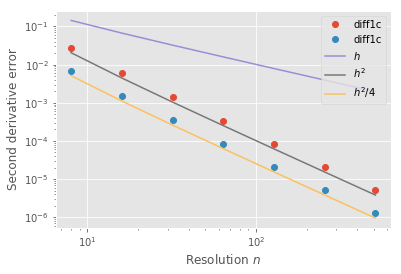

In [7]:
def grid_refinement_error2(f, fpp, diff):
    error = []
    for n in grids:
        x = numpy.linspace(-1, 1, n)
        xx, yy = diff(x, f(x))
        error.append(numpy.linalg.norm(yy - fpp(xx), numpy.inf))
    return grids, error

for diff2 in (diff2a, diff2b):
    ns, error = grid_refinement_error2(numpy.cos, lambda x: -numpy.cos(x), diff2)
    pyplot.loglog(ns, error, 'o', label=diff.__name__)
pyplot.loglog(grids, (grids-1)**(-1.), label='$h$')
pyplot.loglog(grids, (grids-1)**(-2.), label='$h^2$')
pyplot.loglog(grids, .25*(grids-1)**(-2.), label='$h^2/4$')
pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Second derivative error')
pyplot.legend(loc='upper right');

#### Observations

* Both methods are second order accurate
* The `diff2b` method is more accurate than `diff2a` by a factor of 4
* The `diff2a` method cannot compute the derivative at points next to the boundary
* We don't know yet whether either method is stable

## Differentiation as matrices

So far we have written functions of the form `diff(x, u)` that compute derivatives.  These functions happen to have been linear in `u`.  We should be able to write differentiation as a matrix $D$ such that

$$ u'(x) = D u(x) $$

where $x$ is the vector of $n$ discrete points, thus $u(x)$ is also a vector of length $n$.

### Homework 1: Due 2018-09-16 (Sunday)

1. Fork the class repository, clone, and create a directory `hw1` inside the repository.  Add your source file(s) to that directory.
2. Write a function `diffmat(x)` that returns a square matrix $D$ that computes first derivatives at all points.
3. Write a function `diff2mat(x)` that returns a square matrix $D_2$ that computes second derivatives at all points.
4. Use test solutions to determine the order of accuracy of your methods for evenly and non-evenly spaced points.  Which norm did you use?
5. Add `README.md` in the `hw1` directory and summarize your results (one paragraph or a few bullet items is fine).
6. Commit (`git commit`) your source code and `README.md` in the `hw1` directory and push to your fork.  I'll pull from there after the due date.


* You may assume that the points `x` are monotonically increasing.
* You'll need to think about what to do at the endpoints.

## Boundary conditions

Our boundary value problem states a differential equation to be satisfied in the interior of the domain, combined with Dirichlet conditions at the left endpoint and Neumann at the right endpoint.

### Dirichlet
The left endpoint in our example BVP has a Dirichlet boundary condition,
$$u(-1) = a . $$
With finite difference methods, we have an explicit degree of freedom $u_0 = u(x_0 = -1)$ at that endpoint.
When building a matrix system for the BVP, we can implement this boundary condition by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{1:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{1:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{1:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.
* We can eliminate $u_0$ and create a reduced system for $u_{1:}$.  We will describe this for a more general $2\times 2$ block system of the form
$$ \begin{bmatrix} I & 0 \\ A_{10} & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 \end{bmatrix} .$$
We can rearrange as
$$ A_{11} u_1 = f_1 - A_{10} f_0 $$
which is symmetric if $A_{11}$ is.  This is sometimes called "lifting" and is often done implicitly in the mathematics literature.  It is convenient for linear solvers and eigenvalue solvers, but inconvenient for IO and postprocessing, as well as some nonlinear problems.  For this reason, it may be preferable to write
$$ \begin{bmatrix} I & 0 \\ 0 & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 - A_{10} f_0 \end{bmatrix} $$
which is symmetric and entirely decouples the degrees of freedom associated with the boundary.  This method turns out to be relatively elegant for nonlinear solvers.

* It is sometimes useful to scale the identity by some scalar related to the norm of $A_{11}$.

## Neumann
The right endpoint in our example BVP has a Neumann boundary condition,
$$ \frac{du}{dx}(1) = b . $$
With finite difference methods, there are generally two ways to derive an equation for the value $u_n = u(x_n = 1)$.  The first is to use a one-sided difference formula as in
$$ \frac{u_n - u_{n-1}}{h} = b . $$
This requires an extra discretization choice and it may not be of the same order of accuracy as the interior discretization and may destroy symmetry.

An alternative is to temporarily introduce a ghost value $u_{n+1} = u(x_{n+1} = 1 + h)$ (possibly more) and define it to be a reflection of the values from inside the domain.  In the case $b=0$, this reflection is $u_{n+i} = u_{n-i}$.  More generally, we can bias the reflection by the slope $b$,
$$ u_{n+i} = u_{n-i} + 2b(x_n - x_{n-i}) . $$
After this definition of ghost values, we apply the interior discretization at the boundary.  For our reference equation, we would write

$$ \frac{-u_{n-1} + 2 u_n - u_{n+1}}{h^2} = f(x_n) $$

which simplifies to $$ \frac{u_n - u_{n-1}}{h^2} = f(x_n)/2 + b/h $$
after dividing by 2 and moving the boundary term to the right hand side.

In [8]:
def laplacian(n, rhsfunc, a, b):
    x = numpy.linspace(-1, 1, n+1)
    h = 2 / n
    rhs = rhsfunc(x)
    e = numpy.ones(n)
    L = (2 * numpy.eye(n+1) - numpy.diag(e, 1) - numpy.diag(e, -1)) / h**2
    # Dirichlet condition
    L[0,:] = numpy.eye(1,n+1)
    rhs[0] = a
    rhs[1:] -= L[1:,0] * a
    L[1:,0] = 0
    # Neumann condition
    L[-1,-1] /= 2
    rhs[-1] = b / h + rhs[-1] / 2
    return x, L, rhs
    
laplacian(5, lambda x: 0*x+1, .5, -1)

(array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ]),
 array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  , 12.5 , -6.25,  0.  ,  0.  ,  0.  ],
        [ 0.  , -6.25, 12.5 , -6.25,  0.  ,  0.  ],
        [ 0.  ,  0.  , -6.25, 12.5 , -6.25,  0.  ],
        [ 0.  ,  0.  ,  0.  , -6.25, 12.5 , -6.25],
        [ 0.  ,  0.  ,  0.  ,  0.  , -6.25,  6.25]]),
 array([ 0.5  ,  4.125,  1.   ,  1.   ,  1.   , -2.   ]))

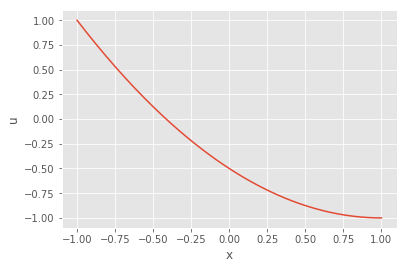

In [9]:
x, L, rhs = laplacian(160, lambda x: 0*x-1, 1, 0)
u = numpy.linalg.solve(L, rhs)
pyplot.plot(x, u);
pyplot.xlabel('x')
pyplot.ylabel('u');

#### Observations

* The reflection formulation maintains symmetry and order of accuracy.
* We'll need to be careful in case of nonlinearity, especially when bounds or positivity are in play. The reflected values could produce negative pressure or density, for example.

## Green's functions

A continuous [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) is the solution of a differential equation where the right hand side is a [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function).  We can compute discrete Green's functions by solving against columns of the identity.

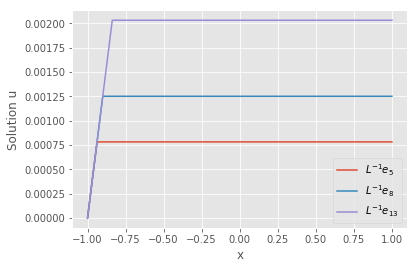

In [10]:
Linv = numpy.linalg.inv(L)
cols = [5, 8, 13]
pyplot.plot(x, Linv[:,cols])
pyplot.xlabel('x')
pyplot.ylabel('Solution u')
pyplot.legend(['$L^{-1} e_{%d}$' % c for c in cols]);

## Spectra and eigenfunctions

An eigenvalue $\lambda$ of the matrix $L$ satisfies
$$ L u = \lambda u $$
and $u$ is called an eigenvector.  The set of all eigenvalues $\lambda$ is called the spectrum of $L$.

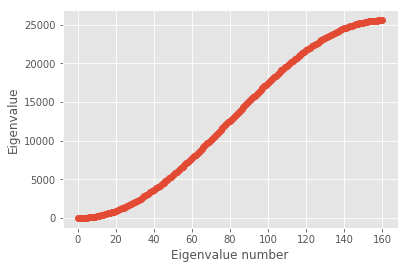

In [11]:
x, L, _ = laplacian(160, lambda x: 0*x, 1, 0)
lam, U = numpy.linalg.eigh(L)

pyplot.plot(lam, 'o')
pyplot.xlabel('Eigenvalue number')
pyplot.ylabel('Eigenvalue');

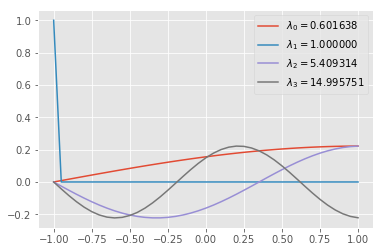

In [12]:
x, L, rhs = laplacian(40, lambda x: 0*x+1, 1, -.5)
lam, U = numpy.linalg.eigh(L)
for i in (0, 1, 2, 3):
    pyplot.plot(x, U[:,i], label='$\lambda_{%d} = %5f$'%(i, lam[i]))
pyplot.legend(loc='upper right');

### Note on stability

Above, we see evidence of stability in that all the eigenvalues are positive and the eigenvectors associated with the smallest eigenvalues are low frequency (ignoring the mode corresponding to the Dirichlet boundary).  Specifically, there are no "noisy" functions with eigenvalues close to zero.

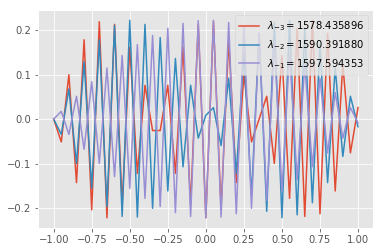

In [13]:
for i in (-3, -2, -1):
    pyplot.plot(x, U[:,i], label='$\lambda_{%d} = %5f$'%(i, lam[i]))
pyplot.legend(loc='upper right');

## Manufactured solutions

Let's choose a smooth function with rich derivatives,
$$ u(x) = \tanh(x) . $$
Then $$ u'(x) = \cosh^{-2}(x) $$ and $$ u''(x) = -2 \tanh(x) \cosh^{-2}(x) . $$

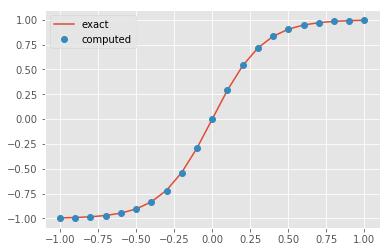

In [14]:
def uexact(x):
    return numpy.tanh(3*x)
def duexact(x):
    return 3*numpy.cosh(3*x)**(-2)
def negdduexact(x):
    return 3**2 * 2 * numpy.tanh(3*x) * numpy.cosh(3*x)**(-2)

x, L, f = laplacian(20, negdduexact, uexact(-1), duexact(1))
u = numpy.linalg.solve(L, f)
pyplot.plot(x, uexact(x), label='exact')
pyplot.plot(x, u, 'o', label='computed')
pyplot.legend(loc='upper left');

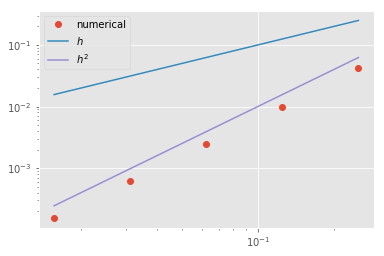

In [15]:
def mms_error(n, discretize):
    x, L, f = discretize(n, negdduexact, uexact(-1), duexact(1))
    u = numpy.linalg.solve(L, f)
    return numpy.linalg.norm(u - uexact(x), numpy.inf)

ns = 2**numpy.arange(3,8)
errors = [mms_error(n, laplacian) for n in ns]
pyplot.loglog(2/ns, errors, 'o', label='numerical')
pyplot.loglog(2/ns, (2/ns), label='$h$')
pyplot.loglog(2/ns, (2/ns)**2, label='$h^2$')
pyplot.legend(loc='upper left');

## The other second order centered discretization

We have been using the discretization

$$ -u''(x_i) \approx \frac{-u_{i-1} + 2 u_i - u_{i+1}}{h^2} $$

which is sometimes summarized using the stencil

$$ h^{-2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} . $$

There is also the discretization arising from applying centered first derivatives twice,

$$ -u''(x_i) \approx \frac{-u_{i-2} + 2 u_i - u{i+2}}{4 h^2} $$

which corresponds to the stencil

$$ (2h)^{-2} \begin{bmatrix} -1 & 0 & 2 & 0 & -1 \end{bmatrix} . $$

We'll reuse the boundary condition handling and keep the first stencil at the points adjacent to the boundaries, $x_1$ and $x_{n-1}$, but apply this discretization for true interior points.

In [16]:
def laplacian2(n, rhsfunc, a, b):
    x, L, rhs = laplacian(n, rhsfunc, a, b)
    h = 2 / n
    L[2:-2,:] = (2 * numpy.eye(n-3, n+1, k=2)
                 - numpy.eye(n-3, n+1, k=0)
                 - numpy.eye(n-3, n+1, k=4)) / (2*h)**2
    return x, L, rhs

laplacian2(6, numpy.cos, 1, 0)

(array([-1.        , -0.66666667, -0.33333333,  0.        ,  0.33333333,
         0.66666667,  1.        ]),
 array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  , 18.  , -9.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [-2.25,  0.  ,  4.5 ,  0.  , -2.25,  0.  ,  0.  ],
        [ 0.  , -2.25,  0.  ,  4.5 ,  0.  , -2.25,  0.  ],
        [ 0.  ,  0.  , -2.25,  0.  ,  4.5 ,  0.  , -2.25],
        [ 0.  ,  0.  ,  0.  ,  0.  , -9.  , 18.  , -9.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -9.  ,  9.  ]]),
 array([1.        , 9.78588726, 0.94495695, 1.        , 0.94495695,
        0.78588726, 0.27015115]))

This matrix is not symmetric due to the discretization used near the boundaries.

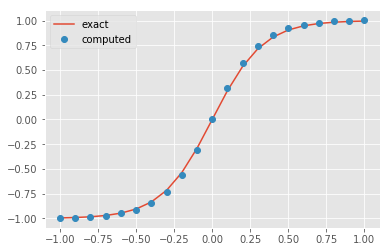

In [17]:
x, L, f = laplacian2(20, negdduexact, uexact(-1), duexact(1))
u = numpy.linalg.solve(L, f)
pyplot.plot(x, uexact(x), label='exact')
pyplot.plot(x, u, 'o', label='computed')
pyplot.legend(loc='upper left');

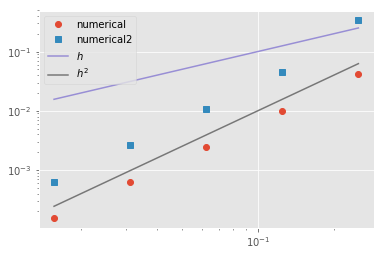

In [18]:
errors = [mms_error(n, laplacian) for n in ns]
errors2 = [mms_error(n, laplacian2) for n in ns]
pyplot.loglog(2/ns, errors, 'o', label='numerical')
pyplot.loglog(2/ns, errors2, 's', label='numerical2')
pyplot.loglog(2/ns, (2/ns), label='$h$')
pyplot.loglog(2/ns, (2/ns)**2, label='$h^2$')
pyplot.legend(loc='upper left');

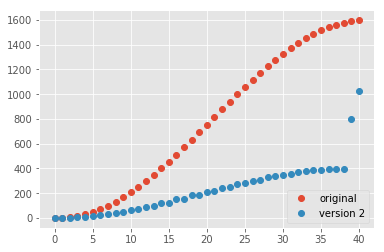

In [19]:
n = 40
x, L, _ = laplacian(n, lambda x: 0*x+1, 1, -1)
_, L2, _ = laplacian2(n, lambda x: 0*x+1, 1, -1)

lam, U = numpy.linalg.eigh(L)
lam2, U2 = numpy.linalg.eig(L2)  # Need to use nonsymmetric eigensolver
idx = numpy.argsort(lam2)
lam2 = lam2[idx]
U2 = U2[:,idx]
pyplot.plot(lam, 'o', label='original')
pyplot.plot(lam2, 'o', label='version 2')
pyplot.legend(loc='lower right');

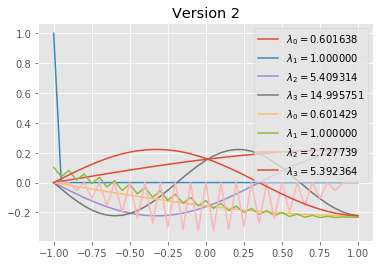

In [20]:
pyplot.figure()
for i in (0, 1, 2, 3):
    pyplot.plot(x, U[:,i], label='$\lambda_{%d} = %5f$'%(i, lam[i]))
pyplot.legend(loc='upper right')
pyplot.title('Original')

for i in (0, 1, 2, 3):
    pyplot.plot(x, U2[:,i], label='$\lambda_{%d} = %5f$'%(i, lam2[i]))
pyplot.legend(loc='upper right')
pyplot.title('Version 2');

### Observations about `laplacian2`

* `laplacian2` converges at the same order of accuracy as `laplacian`
* `laplacian2` is less accurate, especially on coarse/under-resolved grids
* `laplacian2` (with this boundary condition implementation) is nonsingular
* `laplacian2` is a weakly unstable discretization, even away from boundaries

# Fourier analysis of FD methods

Suppose we are operating on an infinite domain with uniform grid spacing $h=1$.  Some finite difference stencils that we have worked with are

In [21]:
stencil_1L = [-1, 1, 0]
stencil_1C = [-1/2, 0, 1/2]
stencil_1R = [0, -1, 1]
stencil_2a = [1, -2, 1]
stencil_2b = [1/4, 0, -1/2, 0, 1/4]

We consider the action of these stencils on the grid functions
$$ \phi(x, \theta) = e^{i \theta x} . $$
For example, take `stencil_2a`
\begin{align}
S \phi(x, \theta) &= \phi(x-1, \theta) - 2 \phi(x, \theta) + \phi(x+1, \theta) \\
&= \underbrace{(2 \cos\theta - 2)}_{\hat S(\theta)} \phi(x, \theta) .
\end{align}

* Show this

Evidently $\phi(x, \theta)$ is an eigenvector of $S$ for every value of $\theta$ and $\hat S(\theta)$ is the corresponding eigenvalue.  We call the function $\hat S(\theta)$ the *symbol* of the stencil $S$.

* We need only consider $-\pi < \theta \le \pi$.  Why?

The exact derivatives of $\phi$ are
\begin{align}
\phi'(x, \theta) &= i \theta \phi(x, \theta) \\
\phi''(x, \theta) &= -\theta^2 \phi(x, \theta) .
\end{align}

* What is the Taylor series for the symbol $2 - 2\cos\theta$?

In [22]:
def symbol(S, theta):
    """Compute the symbol of the stencil S(theta)"""
    if len(S) % 2 != 1:
        raise RuntimeError('Stencil length must be odd')
    w = len(S) // 2 # integer division rounds down
    phi = numpy.exp(1j * numpy.outer(range(-w, w+1), theta))
    return S @ phi

symbol(stencil_2a, [0, numpy.pi/4])

array([ 0.        +0.j, -0.58578644+0.j])

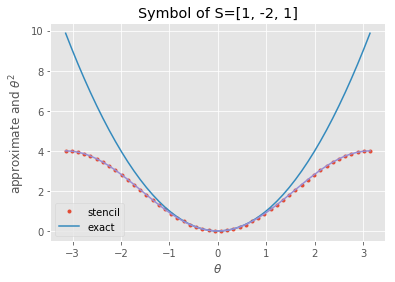

In [23]:
def plot_symbol(S, deriv=2):
    theta = numpy.linspace(-numpy.pi, numpy.pi)
    sym = symbol(S, theta)
    rsym = numpy.real_if_close((-1j)**deriv * sym)
    pyplot.plot(theta, rsym, '.', label='stencil')
    pyplot.plot(theta, theta**deriv, '-', label='exact')
    pyplot.legend()
    pyplot.title('Symbol of S={}'.format(S))
    pyplot.xlabel(r'$\theta$')
    pyplot.ylabel('approximate and $\\theta^{%d}$' % deriv)
    return theta, rsym

theta, _ = plot_symbol(stencil_2a)
pyplot.plot(theta, 2 - 2*numpy.cos(theta));

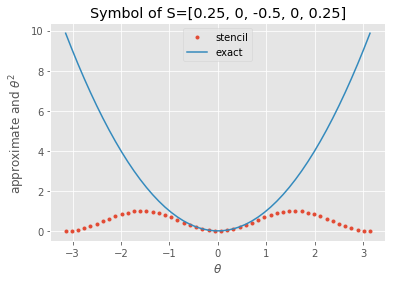

In [24]:
plot_symbol(stencil_2b);

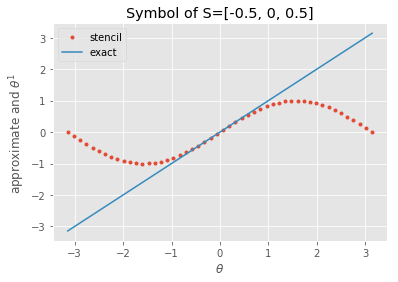

In [25]:
plot_symbol(stencil_1C, deriv=1);

### Observations

* Plotting the symbol tells us about stability (eigenvalues near 0 for high frequency).
* The order of agreement with the exact symbol is the order of the method.
* We can't use it for variable coefficient or boundary conditions.
* We'll use this technique again to optimize solvers like multigrid.